In [1]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn import metrics
from sklearn import feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns


import gensim
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
## for bert language model
#import transformers
import nltk

nltk.download('all')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already 

True

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/train_data.csv')
train_X_Path = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle/train_data.csv"
train_Y_Path = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle/train_results.csv"
test_X_Path = "/content/gdrive/MyDrive/Colab Notebooks/Kaggle/test_data.csv"

In [4]:
# Training data
df = pd.read_csv(train_X_Path)
# Dropping id column
df.drop(['id'],axis=1,inplace=True)
# Training labels
df_train_Y = pd.read_csv(train_Y_Path)
df_train_Y.head()
# Dropping id column
df_train_Y = df_train_Y.drop(columns=['id'],axis=1)
# Converting categorical labels to numeric
df_train_Y.target[df_train_Y.target == 'positive'] = 2
df_train_Y.target[df_train_Y.target == 'negative'] = 0
df_train_Y.target[df_train_Y.target == 'neutral'] = 1
# combining text data and labels to one single dataframe
df = pd.concat([df,df_train_Y],axis=1)

In [5]:
# Text Clean-Up

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=  text.strip()  
    text=  re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text= re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Removes url
    text = re.compile(r'<[^>]+>').sub('', text) #Removes HTML tags:
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) # Single character removal
    text = re.sub(r'\s+', ' ', text) # Remove multiple spaces
    return text

# STOPWORD REMOVAL
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
def remove_stopwords(str):
    return " ".join([word for word in str.split() if word not in stop])

# Clean text without stop words removal
df['clean_text'] = df['text'].map(lambda x: preprocess(x))
#df['clean_text'] = df['clean_text'].map(lambda x: remove_stopwords(x))

# Checking the status of clean text with stop words removed
df['clean_text_len'] = df['clean_text'].apply(lambda x:len(str(x).split()))
print(df['clean_text_len'].sum())
df['clean_text_len'].describe()
# removing samples with zero words
no_text = df[df['clean_text_len']==0]
df.drop(no_text.index,inplace=True)


13156702


In [6]:
new_df = df.clean_text.str.split(expand=True).stack().value_counts().reset_index()
 
new_df.columns = ['Word', 'Frequency']

new_df


,Word,Frequency
0,to,368371
1,the,341615
2,my,206635
3,it,198104
4,and,197391
...,...,...
450421,michey,1
450422,tudumo,1
450423,faitaccompli,1
450424,wnpn,1


In [7]:
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
df['tokens'] = df['clean_text'].apply(lambda x:tokenizer.tokenize(x))
df.head()

,text,target,clean_text,clean_text_len,tokens
0,Anyway Im getting of for a while,2,anyway im getting of for while,6,"[anyway, im, getting, of, for, while]"
1,"My red, Apache isn't feelin too well this morn...",0,my red apache isn feelin too well this morning...,12,"[my, red, apache, isn, feelin, too, well, this..."
2,@danyelljoy you should be its great. friday w...,2,danyelljoy you should be its great friday will...,11,"[danyelljoy, you, should, be, its, great, frid..."
3,its 11:30pm and i dont wanna sleep; so i debat...,2,its pm and dont wanna sleep so debated with my...,22,"[its, pm, and, dont, wanna, sleep, so, debated..."
4,Why does twitter eat my DM's? Not happy,0,why does twitter eat my dm not happy,8,"[why, does, twitter, eat, my, dm, not, happy]"


In [8]:
import gensim

In [9]:
# Label Encoding
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'target'.
df['target']= label_encoder.fit_transform(df['target'])
y = df['target']

X = df['clean_text']

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 42)


In [11]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = df['clean_text_len'].max()
#max_features = int(new_df.shape[0]/2)
max_features = 50000

In [12]:
def Token_padding(data_train, data_test):

  Tokens = Tokenizer(num_words = max_features, oov_token ='OOV')
  Tokens.fit_on_texts(data_train)
  #vocab_size = len(Tokens.word_index) + 1
  encd_rev_train = Tokens.texts_to_sequences(data_train)
  pad_sent_train = pad_sequences(encd_rev_train, maxlen=max_len, padding='post')

  encd_rev_test = Tokens.texts_to_sequences(data_test)
  pad_sent_test = pad_sequences(encd_rev_test, maxlen=max_len, padding='post')

  return pad_sent_train, pad_sent_test

In [13]:
X_train_vector,  X_valid_vector = Token_padding(X_train, X_valid)

Y_train = pd.get_dummies(y_train).values
Y_valid = pd.get_dummies(y_valid).values

print(X_train_vector.shape, X_valid_vector.shape, Y_train.shape,Y_valid.shape)

(832258, 116) (208065, 116) (832258, 3) (208065, 3)


In [18]:
import tensorflow as tf

embed_dim = 300
'''
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_LSTM.summary()
'''
input_dim = X_train_vector.shape[1] 

model = Sequential()
model.add(Dense(128, activation = 'relu', input_dim = input_dim))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation = 'softmax'))


opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100
batch_size = 128

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=5, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True)
history = model.fit(X_train_vector, Y_train, 
                    epochs = epochs, 
                    batch_size=batch_size,
                    validation_data = (X_valid_vector, Y_valid),
                    shuffle = True,
                    callbacks=[es])


Epoch 1/100
6503/6503 [==============================] - 30s 4ms/step - loss: 6.7694 - accuracy: 0.4993 - val_loss: 0.6942 - val_accuracy: 0.4994
Epoch 2/100
6503/6503 [==============================] - 23s 4ms/step - loss: 0.7032 - accuracy: 0.5002 - val_loss: 0.6941 - val_accuracy: 0.5005
Epoch 3/100
6503/6503 [==============================] - 25s 4ms/step - loss: 0.7002 - accuracy: 0.5005 - val_loss: 0.6943 - val_accuracy: 0.5007
Epoch 4/100
6503/6503 [==============================] - 26s 4ms/step - loss: 0.7032 - accuracy: 0.4991 - val_loss: 0.6943 - val_accuracy: 0.5007
Epoch 5/100
6503/6503 [==============================] - 23s 4ms/step - loss: 0.7044 - accuracy: 0.5003 - val_loss: 0.6944 - val_accuracy: 0.4996
Epoch 6/100
6503/6503 [==============================] - 24s 4ms/step - loss: 0.7061 - accuracy: 0.5001 - val_loss: 0.6944 - val_accuracy: 0.4996
Epoch 7/100
6503/6503 [==============================] - 24s 4ms/step - loss: 0.7073 - accuracy: 0.4997 - val_loss: 0.6944 -

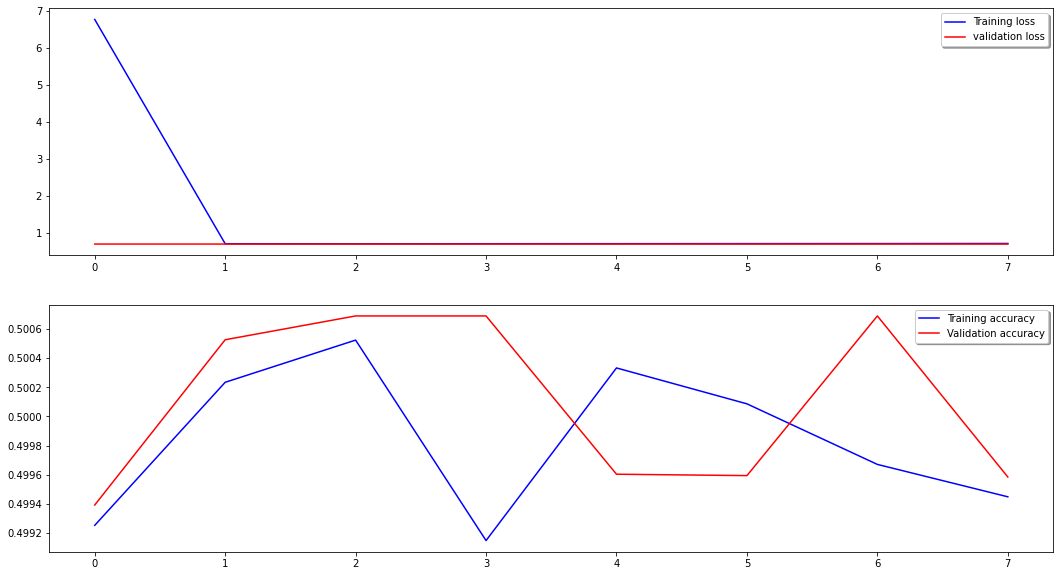

<Figure size 720x720 with 0 Axes>

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

fig = plt.figure(figsize=(10, 10)) # Set Figure

In [20]:
import tensorflow as tf

embed_dim = 300
'''
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    #tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_LSTM.summary()
'''
input_dim = X_train_vector.shape[1] 

model = Sequential()
model.add(Dense(512, activation = 'relu', input_dim = input_dim))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation = 'softmax'))


opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 100
batch_size = 128

es = keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=5, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True)
history = model.fit(X_train_vector, Y_train, 
                    epochs = epochs, 
                    batch_size=batch_size,
                    validation_data = (X_valid_vector, Y_valid),
                    shuffle = True,
                    callbacks=[es])


Epoch 1/100
6503/6503 [==============================] - 30s 4ms/step - loss: 3.3225 - accuracy: 0.5088 - val_loss: 0.6947 - val_accuracy: 0.5187
Epoch 2/100
6503/6503 [==============================] - 31s 5ms/step - loss: 0.7018 - accuracy: 0.5019 - val_loss: 0.6956 - val_accuracy: 0.4993
Epoch 3/100
6503/6503 [==============================] - 31s 5ms/step - loss: 0.6986 - accuracy: 0.4988 - val_loss: 0.6947 - val_accuracy: 0.4993
Epoch 4/100
6503/6503 [==============================] - 32s 5ms/step - loss: 0.6971 - accuracy: 0.5010 - val_loss: 0.6947 - val_accuracy: 0.4993
Epoch 5/100
6503/6503 [==============================] - 31s 5ms/step - loss: 0.6971 - accuracy: 0.5000 - val_loss: 0.6942 - val_accuracy: 0.5006
Epoch 6/100
6503/6503 [==============================] - 31s 5ms/step - loss: 0.6966 - accuracy: 0.5000 - val_loss: 0.6944 - val_accuracy: 0.5006
Epoch 6: early stopping


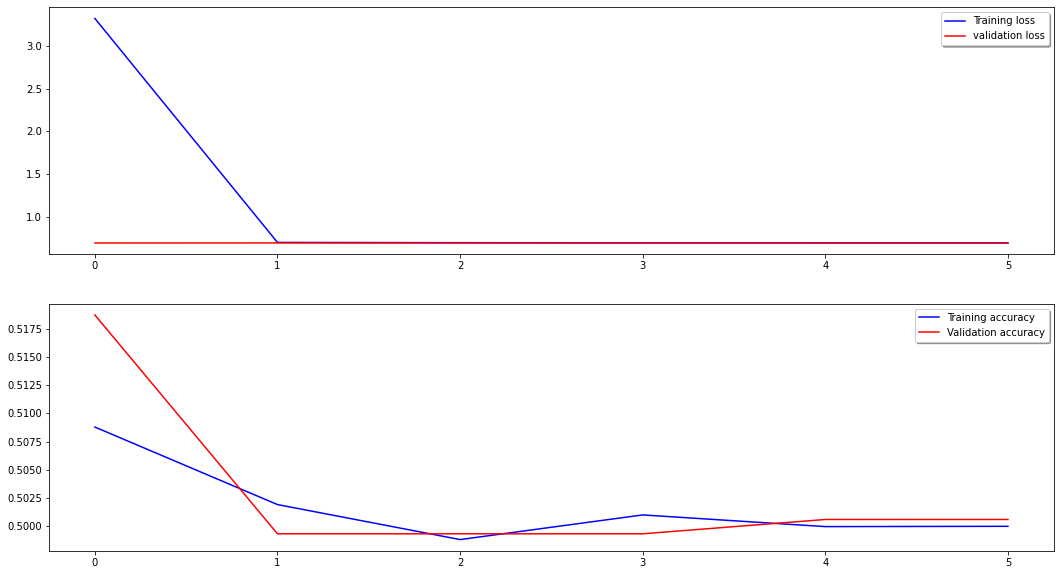

<Figure size 720x720 with 0 Axes>

In [21]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

fig = plt.figure(figsize=(10, 10)) # Set Figure


In [ ]:
#

In [ ]:
#

In [ ]:
#